#Сравнение алгоритмов мультиноминальной классификации текста
Шаг 1. Векторизация входных данных
-----------------------------------
Импортируем нужные библиотеки

In [ ]:
import pandas as pd # Чтение датасета
from transformers import BertTokenizer, BertModel # Трансформеры токеенайзера и модели Берт
import torch
import numpy as np
from multiprocessing import Pool # Многопоточность процесса векторизации

In [ ]:
data = pd.read_csv('/home/herb/vk-project/articles_lemmatized_no_SW.csv')
data['text'] = data['headline'] + ' ' + data['body']

Читаем датасет, соединяем столбцы заголовка и тела в один для тренировки модели

In [ ]:
tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')
model = BertModel.from_pretrained('DeepPavlov/rubert-base-cased')
def get_bert_embeddings_batch(batch_texts):
    inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt', max_length=256)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[:, 0, :].numpy()

    return embeddings

def get_bert_embeddings(texts, batch_size=16):
    all_embeddings = []
    batches = [texts[i:i + batch_size] for i in range(0, len(texts), batch_size)]

    with Pool(processes=12) as pool:
        results = pool.map(get_bert_embeddings_batch, batches)

    all_embeddings = np.vstack(results)

    return all_embeddings


В качестве модели для векторизации статей будем использовать RuBert Base, содержащую 180М параметров, как самую большую русскоязычную опенсорс Берт-модель.
Определим две функции для векторизации: get_bert_embeddings будет передавать параметры в многопоток get_bert_embeddings_batch, которая, в свою очередь,
возвращает эмбеддинги переданных текстов.

In [ ]:
texts = []
labels = []
for index, row in data.iterrows():
    if isinstance(row['text'], str) and isinstance(row['topic'], str):
        texts.append(row['text'])
        labels.append(row['topic'])

embeddings = get_bert_embeddings(texts)

Итерируем по всем рядам датасета, сохраняем валидные; запускаем процесс векторизации.

*Примечание:* последующая тренировка моделей на выбранных алгоритмах производилась в отдельных файлах, поэтому полученные эмбеддинги были сохранены в отдельный датасет:

In [ ]:
embeddings_df = pd.DataFrame(embeddings)
embeddings_df['topic'] = labels
embeddings_df.to_csv('embeddings_with_topics.csv', index=False)

Шаг 2. Тренировка и сохранение метрик моделей
--------------------------
Выбранные алгоритмы классификации:


*   К-ближайших соседей
*   Мультиноминальный наивный байесовский классификатор
*   Логистическая регрессия с стохастическим градиентным спуском
*   Классификатор опорных векторов

Скрипт тренировки модели для каждого из алгоритмов выглядит примерно одинаково. Для примера, тренировка модели алгоритмом наивного байесовского классификатора:


In [ ]:
import pandas as pd # Чтение датасета
import time # Будем замерять время тренировки и предикта
from sklearn.model_selection import train_test_split # Разделение датасета на тренировочный и тестовый
from sklearn.naive_bayes import MultinomialNB # Сам алгоритм классификации
from sklearn.metrics import classification_report # Вывод метрик модели
from joblib import dump # Сохранение модели
import json # Сохранение метрик модели из classification_report

Импорт необходимых библиотек.

In [ ]:
data = pd.read_csv('/home/herb/vk-project/embeddings_with_topics.csv')
data['embeddings'] = data.apply(lambda row: [row[str(i)] for i in range(row.size-1)], axis=1)
embeddings = data['embeddings'].tolist()
for row in embeddings:
    for i in range(len(row)):
        row[i] = float(row[i])+4
labels = data['topic'].tolist()


Чтение датасета векторов. Цикл по рядам уникален для этого алгоритма, т.к. в нем каждое значение из входных данных должно быть неотрицательным. (Было выявлено минимальное отрицательное значение из всех векторов: -3.5..., затем ко всем значениям всех векторов была прибавлена константа 4)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42)

nb = MultinomialNB()
start_time = time.time()
nb.fit(X_train, y_train)
training_time = time.time() - start_time
dump(nb, 'nb.joblib')

start_time = time.time()
y_pred = nb.predict(X_test)
prediction_time = time.time() - start_time

Разбиваем датасет на тренировочный и тестовый, инициализируем модель. Засекаем время, начинаем процесс тренировки. Сохраняем натренированную модель, предиктим классы тестового датасета.

In [ ]:
metrics = classification_report(y_test, y_pred, output_dict=True)
metrics['Training time'] = training_time
metrics['Prediction time'] = prediction_time
print(metrics)
with open('nb-metrics.json', 'w') as f:
    json.dump(metrics, f)

Выводим и сохраняем метрики, в т.ч. время, которое ушло на тренировку модели.

Шаг 3. Визуализация собранных метрик
--------------------------
Сравнивать модели, натренированные на каждом из алгоритмов, будем по следующим метрикам:
*    средневзвешенные значения (ввиду имбаланса количества статей по классам) точности (precision), полноты (recall) и f1-метрики (f1-score);
*    время тренировки;
*    время прогнозирования тестового датасета;
*    размера натренированной модели.

Для сбора соответствующих данных обратимся к сохраненным ранее JSON-файлам метрик каждой модели и построим графики с помощью matplotlib:


In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os

data = {}
for algo in ('nb', 'knn', 'svc', 'sgd'):
    with open(f'{algo}-metrics.json') as f:
        algo_metrics = json.load(f)
        algo_metrics = {"weighted avg precision" : algo_metrics["weighted avg"]["precision"],
               "weighted avg recall" : algo_metrics["weighted avg"]["recall"],
               "weighted avg f1-score" : algo_metrics["weighted avg"]["f1-score"],
               "training time" : algo_metrics["Training time"],
               "prediction time" : algo_metrics["Prediction time"],
               "model_size (MB)" : os.stat(f'{algo}.joblib').st_size / (1024 * 1024)}
        data[algo] = algo_metrics

В этом цикле мы итерируем по всем выбранным алгоритмам и собираем один словарь, где ключами являются названия алгоритмов, а значениями - метрики модели, натренированной на каждом из алгоритмов.

In [ ]:
algorithms = list(data.keys())
metrics = list(data[algorithms[0]].keys())
metric_values = [[data[algo][metric] for algo in algorithms] for metric in metrics]
positions = np.arange(len(algorithms))

for i, metric in enumerate(metrics):
    fig, ax = plt.subplots()
    ax.bar(positions + i * 0.1, metric_values[i], width=0.1, color='r', label=metric)
    ax.set_xticks(positions + 0.2)
    ax.set_xticklabels(algorithms)
    ax.set_xlabel('Алгоритм')
    ax.set_ylabel('Значение')
    ax.set_title('Сравнение алгоритмов')
    ax.legend()
    fig.autofmt_xdate()
    plt.savefig(f'{metric}_comparison_plot.png')
    plt.clf()


Сохраняем графы. Графы содержат в себе результат каждого из алгоритмов по какой-то из метрик.

Шаг 4. Сравнение алгоритмов
------------------------------
1. Средневзвешенные значения точности, полноты и f1-метрики:

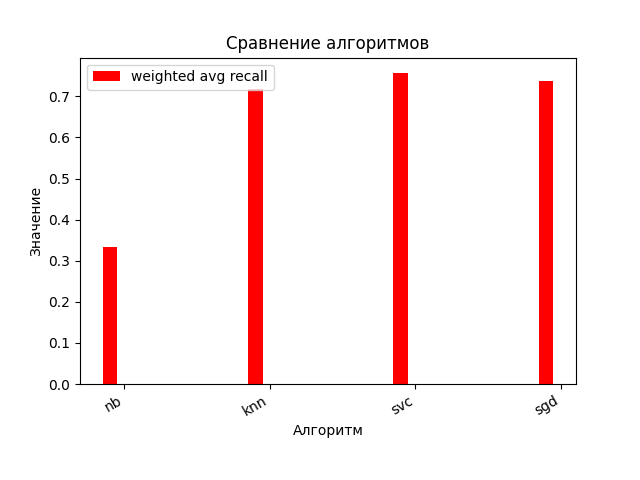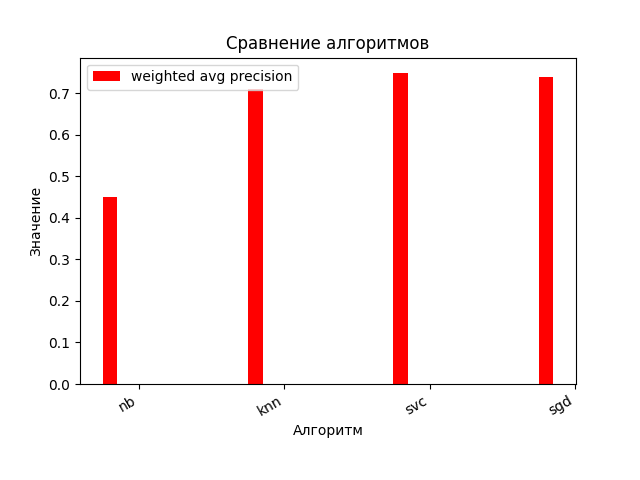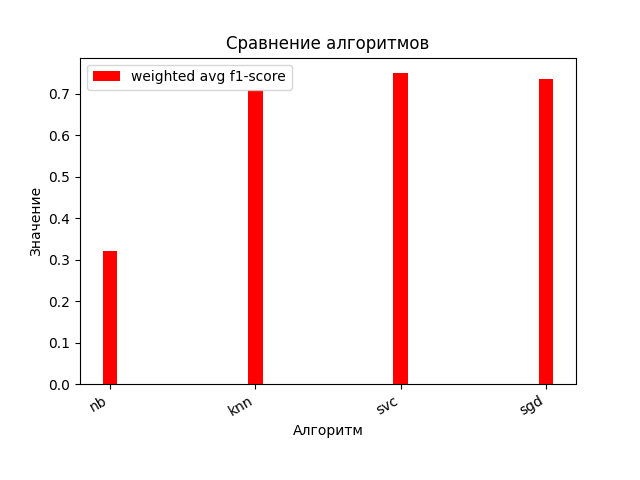

По этим параметрам явно отстающим можно выделить лишь алгоритм наивного байесовского классификатора.


2. Время тренировки модели:

  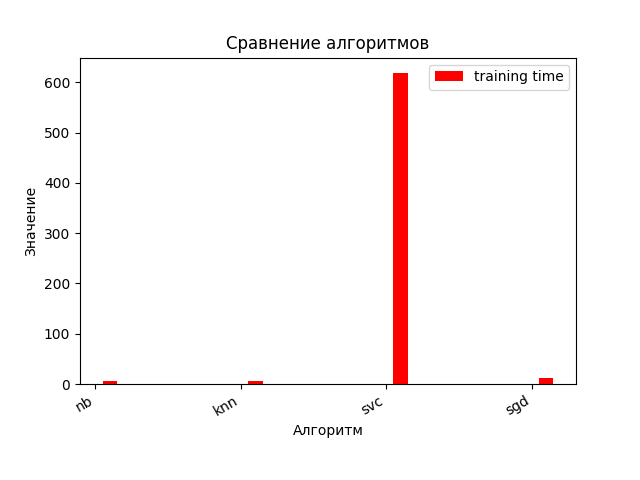

Все алгоритмы, кроме классификаторе опорных векторов, который, к тому же, не поддерживает многопоточную тренировку (в отличие от, например, линейной регрессии), показывают на мощностях виртуальной машины, на котороый они тренировались, время меньшее 10 секунд. Модель, основанная на классификаторе опорных векторов, тренировалась более 10 минут.


3. Время прогнозирования тестового датасета (11300 текстов)

  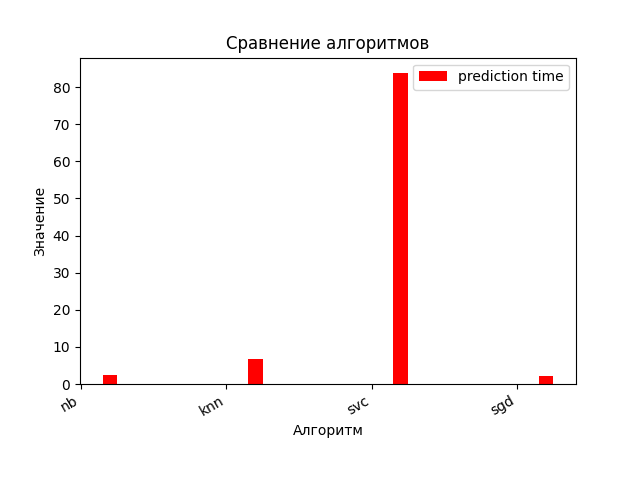

Ситуация, аналогичная метрике тренировочного времени. SVC - дольше всех.


4. Размер модели

  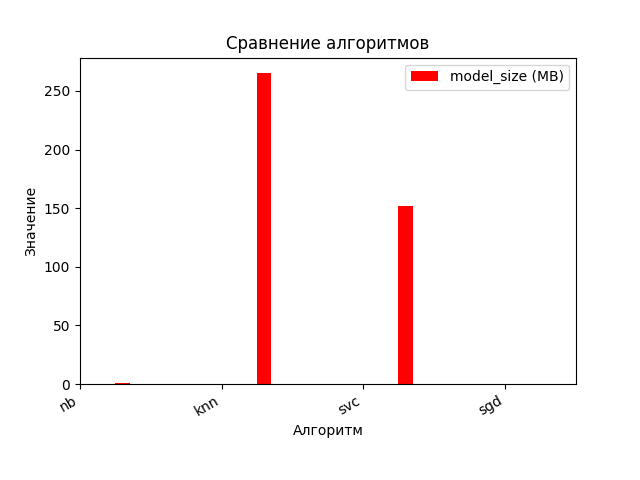

Метрика размера натренированной модели выделяет два алгоритма - K-ближайших соседей и SVC.

Шаг 5. Вывод
----------------
Для вывода из данных о решении этой задачи очень важен факт того, что данный датасет был предобработан - все слова текстов статей были лемматизированы, тексты очищены от стоп-слов.

Натренированная на нем модель показывает результаты слегка более высокие, чем остальные. В таких условиях нам, чаще всего, не нужен настолько тяжелый в плане вычислений и памяти алгоритм, как классификатор опорных векторов. Наивный байесовский классификатор тоже не подходит - оригинальный алгоритм предназначался для бинарной классификации, и мультиноминальный аналог не совсем хорошо справляется с задачей, явно отставая по метрикам от конкурентов.

Окончательный выбор между KNN и LR зависит от возможностей машины, на котой билдят модель: KNN - очень простой алгоритм, не требующий процесса тренировки как такового, но взамен занимающий большое количество памяти и имеющий время прогнозирование в 3 раза больше конкурента (6s и 2s соответственно).
Linear regression же - довольно тяжелый алгоритм, дающий, чаще всего, более точный результат, но при этом скорость его тренировки в данном сравнении спасла лишь возможность многопоточности.